In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from pathlib import Path

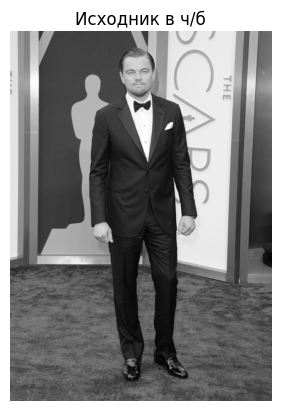

In [13]:
# 1. Загрузка и предварительная обработка изображения
path = Path(r'./additional/photoHOG.jpg')
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # HOG работает с ч/б
plt.imshow(img, cmap='gray')
plt.title('Исходник в ч/б')
plt.axis('off')
plt.show()

In [14]:
img = cv2.resize(img, (64, 128))  # стандартный размер для HOG

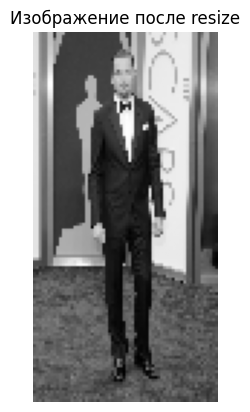

In [15]:
plt.imshow(img, cmap='gray')
plt.title('Изображение после resize')
plt.axis('off')
plt.show()

In [16]:
# 2. Вычисление градиентов по X и Y
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)

In [17]:
# 3. Вычисление величины и направления градиента
magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
angle = np.mod(angle, 180) # зеркалим углы больше 180, так как в HOG у нас unsigned gradient angles

In [18]:
# 4. Квантование углов: 9 интервалов (0–160) → индексы от 0 до 8
num_bins = 9
angle_quantized = np.floor(angle / 20).astype(int)
angle_quantized[angle_quantized == num_bins] = num_bins - 1  # чтобы 180° не ушло за предел

In [19]:
# 5. Разделение изображения на ячейки (8x8 пикселей)
cell_size = 8
cells_x = img.shape[1] // cell_size
cells_y = img.shape[0] // cell_size

In [20]:
# 6. Построение гистограммы направлений градиента для каждой ячейки
hog = np.zeros((cells_y, cells_x, num_bins), dtype=np.float32)

for y in range(cells_y):
    for x in range(cells_x):
        cell_mag = magnitude[y*cell_size:(y+1)*cell_size, x*cell_size:(x+1)*cell_size]
        cell_angle = angle_quantized[y*cell_size:(y+1)*cell_size, x*cell_size:(x+1)*cell_size]
        for i in range(cell_size):
            for j in range(cell_size):
                bin_idx = cell_angle[i, j]
                hog[y, x, bin_idx] += cell_mag[i, j]

In [21]:
# 7. Нормализация блоков (2x2 ячейки = 16x16 пикселей)
block_size = 2
eps = 1e-6
hog_normalized = []

for y in range(cells_y - block_size + 1):
    for x in range(cells_x - block_size + 1):
        block = hog[y:y+block_size, x:x+block_size, :].flatten()
        norm = np.linalg.norm(block) + eps
        hog_normalized.append(block / norm)

In [22]:
# 8. Финальный вектор признаков равен 3780 (105 векторов размером 36*1) 36 = 9 дискретных значений углов на 4 ячейки в блоке
hog_descriptor = np.concatenate(hog_normalized)

print("Размер дескриптора HOG:", hog_descriptor.shape)

Размер дескриптора HOG: (3780,)


Все действия выше позволили нам получить HOG-дескриптор, то есть представить изображение в виде вектора.

Далее необходимо на каком-то датасете (в зависимости от задачи) вычислить HOG-вектор для каждого изображения из этого датасета и затем обучить классификатор на этих векторах. Чаще всего применяется SVM.

И ещё в базовом примере выше мы делаем resize изображения под размер 64 на 128 (так было в оригинале) и, собственно, видим, как изображению поплохело.
Сейчас мы будем использовать скользящее окно, чтобы работать с изображением, разбивая его на перекрывающися окна нужного размера, то есть мы сможем принимать на вход любые изображения и не портить их, сжимая до 64*128. Распознавать будем сидуэты людей.

In [23]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [24]:
# 1. Собираем вычисление HOG-дескриптора в функцию
def compute_hog_descriptor_from_patch(img):
    img = cv2.resize(img, (64, 128))
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    angle = np.mod(angle, 180)

    num_bins = 9
    angle_quantized = np.floor(angle / 20).astype(int)
    angle_quantized[angle_quantized >= num_bins] = num_bins - 1

    cell_size = 8
    cells_x = img.shape[1] // cell_size
    cells_y = img.shape[0] // cell_size
    hog = np.zeros((cells_y, cells_x, num_bins), dtype=np.float32)

    for y in range(cells_y):
        for x in range(cells_x):
            cell_mag = magnitude[y*cell_size:(y+1)*cell_size, x*cell_size:(x+1)*cell_size]
            cell_angle = angle_quantized[y*cell_size:(y+1)*cell_size, x*cell_size:(x+1)*cell_size]
            for i in range(cell_size):
                for j in range(cell_size):
                    bin_idx = cell_angle[i, j]
                    hog[y, x, bin_idx] += cell_mag[i, j]

    block_size = 2
    eps = 1e-6
    hog_normalized = []
    for y in range(cells_y - block_size + 1):
        for x in range(cells_x - block_size + 1):
            block = hog[y:y+block_size, x:x+block_size, :].flatten()
            norm = np.linalg.norm(block) + eps
            hog_normalized.append(block / norm)

    return np.concatenate(hog_normalized)

In [25]:
# 2. Делим исходное изображение на окна нужного размера
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]]) # возвращаем верхний левый угол и сам патч

In [26]:
# 3. Обучение SVM
def load_dataset(positive_dir, negative_dir):
    X, y = [], []
    for path in Path(positive_dir).glob('*.jpg'):
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        X.append(compute_hog_descriptor_from_patch(img))
        y.append(1)
    for path in Path(negative_dir).glob('*.jpg'):
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        X.append(compute_hog_descriptor_from_patch(img))
        y.append(0)
    return np.array(X), np.array(y)

In [27]:
# 4. Детекция объектов
def detect_objects_with_custom_hog(image, clf, step_size=16, window_size=(64, 128)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    detections = []
    for (x, y, window) in sliding_window(gray, step_size, window_size):
        if window.shape[0] != 128 or window.shape[1] != 64:
            continue
        hog_vec = compute_hog_descriptor_from_patch(window)
        pred = clf.predict([hog_vec])
        if pred[0] == 1:
            detections.append((x, y, window_size[0], window_size[1]))
    return detections

In [28]:
# 5. Отрисовка рамок
def draw_detections(image, detections):
    for (x, y, w, h) in detections:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image

In [27]:
import cv2
from pathlib import Path

input_dir = Path('./additional/dataset_hog/positive')
output_dir = input_dir  # сохраняем в ту же папку

for path in input_dir.glob('*.png'):
    img = cv2.imread(str(path))
    if img is None:
        print(f"Не удалось прочитать: {path}")
        continue
    new_path = path.with_suffix('.jpg')
    cv2.imwrite(str(new_path), img)
    path.unlink()  # удаляем оригинальный .png
    print(f"Конвертировано: {path.name} → {new_path.name}")

Конвертировано: crop001001.png → crop001001.jpg
Конвертировано: crop001002.png → crop001002.jpg
Конвертировано: crop001003.png → crop001003.jpg
Конвертировано: crop001004.png → crop001004.jpg
Конвертировано: crop001005.png → crop001005.jpg
Конвертировано: crop001006.png → crop001006.jpg
Конвертировано: crop001007.png → crop001007.jpg
Конвертировано: crop001008.png → crop001008.jpg
Конвертировано: crop001009.png → crop001009.jpg
Конвертировано: crop001010.png → crop001010.jpg
Конвертировано: crop001011.png → crop001011.jpg
Конвертировано: crop001012.png → crop001012.jpg
Конвертировано: crop001013.png → crop001013.jpg
Конвертировано: crop001014.png → crop001014.jpg
Конвертировано: crop001015.png → crop001015.jpg
Конвертировано: crop001016.png → crop001016.jpg
Конвертировано: crop001017.png → crop001017.jpg
Конвертировано: crop001018.png → crop001018.jpg
Конвертировано: crop001019.png → crop001019.jpg
Конвертировано: crop001020.png → crop001020.jpg
Конвертировано: crop001021.png → crop001

In [29]:
# Запуск
if __name__ == "__main__":
    # Путь к обучающим данным
    pos_dir = './additional/dataset_hog/positive'
    neg_dir = './additional/dataset_hog/negative'

    print("Загрузка и обучение...")
    X, y = load_dataset(pos_dir, neg_dir)
    print("Классы", np.unique(y, return_counts=True))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LinearSVC()
    clf.fit(X_train, y_train)
    print(classification_report(y_test, clf.predict(X_test)))

Загрузка и обучение...
Классы (array([0, 1]), array([152, 614]))
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        36
           1       0.96      0.98      0.97       118

    accuracy                           0.95       154
   macro avg       0.95      0.92      0.93       154
weighted avg       0.95      0.95      0.95       154



In [36]:
def non_max_suppression_fast(boxes, overlap_thresh=0.3):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    pick = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        suppress = [last]
        for pos in range(0, last):
            j = idxs[pos]

            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = (w * h) / areas[j]

            if overlap > overlap_thresh:
                suppress.append(pos)

        idxs = np.delete(idxs, suppress)

    return boxes[pick].astype(int).tolist()

In [38]:
# Детекция на новом изображении
test_img = cv2.imread('./additional/dataset_hog/test2.jpg')
detections = detect_objects_with_custom_hog(test_img, clf)
detections = non_max_suppression_fast(detections, overlap_thresh=0.3)
result = draw_detections(test_img.copy(), detections)

cv2.imwrite('./additional/dataset_hog/result2.jpg', result)

True

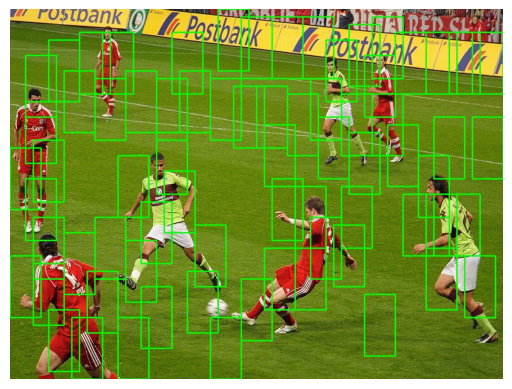

In [41]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./additional/dataset_hog/result1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV читает в BGR, а matplotlib ожидает RGB

plt.imshow(img)
plt.axis('off')  # убрать оси
plt.show()

Как видим, детекция очень не очень. Причины: неравномерно распределены изображения в папках positive и negative и их в целом недостаточно много + это самая что ни на есть классическая реализация метода, нужно попробовать его оптимизировать и обучить на датасете посерьёзнее.